In [5]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import qp
import copy
from rail.core.stage import RailStage
from rail.raruma import utility_functions as raruma_util
from rail.raruma import plotting_functions as raruma_plot
from rail.raruma import admixture_functions as raruma_admix
from rail.raruma import wrapper_classes as raruma_wrap
from scipy.stats import sigmaclip
from astropy.stats import biweight_location, biweight_scale
import hashlib


In [6]:
import os

# pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'  
# if that fails you can use this
# pz_dir = '/global/u2/e/echarles/dx'
#pz_dir = '/Users/echarles/pz'

# use user home directory
#pz_dir = os.path.expanduser('~')

# use user home directory plus additional folder
#pz_dir = os.path.expanduser('~') + '/pz'
pz_dir = os.path.expanduser('~') + '/dev'

print("pz_dir:",pz_dir)

pz_dir: /home/phoenix/dev


In [7]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [10]:
#train = tables_io.read(f"{pz_dir}/data/train/dp1_matched_v4_train.hdf5")
#test = tables_io.read(f"{pz_dir}/data/test/dp1_matched_v4_test.hdf5")
train = tables_io.read(f"{pz_dir}/data/train/dp1_ecdfs_matched_specgold_train.hdf5")
test = tables_io.read(f"{pz_dir}/data/test/dp1_ecdfs_matched_specgold_test.hdf5")

#d.keys()
#train = tables_io.sliceObj(d, slice(0, -1, 10))
#test = tables_io.sliceObj(d, slice(1, -1, 10))

#model_dir = "/projects/dp1_v4/data/gold_baseline"
#model_dir = ''

In [11]:
from rail.estimation.algos.k_nearneigh import KNearNeighInformer, KNearNeighEstimator
from rail.utils.catalog_utils import RubinCatalogConfig

RubinCatalogConfig.apply("com_cam")
#band_names = raruma_util.make_band_names('LSST_obs_{band}', 'ugrizy')
#error_band_names = raruma_util.make_band_names('LSST_obs_{band}_err', 'ugrizy')

In [12]:
KNearNeighInformer.config_options.keys()

dict_keys(['output_mode', 'hdf5_groupname', 'zmin', 'zmax', 'nzbins', 'nondetect_val', 'mag_limits', 'bands', 'ref_band', 'redshift_col', 'trainfrac', 'seed', 'sigma_grid_min', 'sigma_grid_max', 'ngrid_sigma', 'leaf_size', 'nneigh_min', 'nneigh_max', 'only_colors'])

In [13]:
# astra ·₊✧ 12/2025 .⋆˚★ Uncertainty quantification
# Uncertainty extraction: calculates standard deviation of redshift PDFs
# Adapted from Plot_pdfs my_mean_std
#
#  Input: qp_dstn (qp.Ensemble object), grid (redshift grid array)
#  Output: Standard deviation for each PDF, shape (n_galaxies, 1)

def calc_std(qp_dstn, grid):
    pdfs = qp_dstn.pdf(grid)  # Get PDF values on grid
    norms = pdfs.sum(axis=1)  # Normalize
    means = np.sum(pdfs * grid, axis=1) / norms  # Calculate mean redshift
    diffs = (np.expand_dims(grid, -1) - means).T  # Distance from mean
    wt_diffs = diffs * diffs * pdfs  # Weighted squared differences
    stds = np.sqrt((wt_diffs).sum(axis=1)/norms)  # Standard deviation
    return np.expand_dims(stds, -1)

In [28]:
# astra ·₊✧ 12/2025 .⋆˚★ Functions to add noise to the data

# Add Gaussian noise to magnitude measurements
#
#  Input: input_dict (dict from tables_io.read)
#         noise_levels (scalar for uniform noise OR array of length n_galaxies for per-galaxy noise)
#  Output: new dict with noisy magnitudes
#  Contributor: astra ·₊✧ 12/2025

def smear_data(input_dict, noise_levels):
    # ---- INPUT HANDLING ----
    # Extract magnitude columns into 2D array (n_galaxies, 6)
    train_features = raruma_util.get_band_values(input_dict, '{band}_gaap1p0Mag', 'ugrizy')
    n_galaxies = train_features.shape[0]
    
    # Handle scalar vs per-galaxy noise input
    
    # If scalar noise_levels => Uniform noise across entire dataset
    if np.isscalar(noise_levels):
        noise_array = noise_levels * np.ones(n_galaxies)
        
    # If array of length n_galaxies => Apply per-galaxy noise
    elif isinstance(noise_levels, np.ndarray) and len(noise_levels) == n_galaxies:
        noise_array = noise_levels
        
    # Else (array of other length)
    else:
        raise ValueError(f"noise_levels must be scalar or array of length {n_galaxies}, got length {len(noise_levels)}")
    
    
    # ---- ADD NOISE ----
    
    # Add Gaussian noise - gaussian_noise expects (n_bands, n_galaxies) input, performs a transpose
    noisy_mags = raruma_admix.gaussian_noise(train_features.T, noise_levels=noise_array)

    # Create output dictionary (copy input to preserve original)
    output_dict = copy.deepcopy(input_dict)
    
    # Write noisy magnitudes into output dictionary
    for i, band in enumerate('ugrizy'):
        output_dict[f'{band}_gaap1p0Mag'] = noisy_mags[:, i]
    
    return output_dict


# Create heterogeneous training set with varying noise levels assigned randomly
#
#  Input: data (dict), noise_levels (array of noise values)
#  Output: new dict with heterogeneous noise applied
#  Contributor: astra ·₊✧ 12/2025

def create_mixed_noise_data(data, noise_levels):
    n_galaxies = len(data['redshift'])
    n_levels = len(noise_levels)
    
    # Randomly assign each galaxy to a noise level
    noise_assignments = np.random.choice(n_levels, size=n_galaxies)
    
    # Build per-galaxy noise array based on random noise level assignments
    per_galaxy_noise = noise_levels[noise_assignments]
     
    # Apply noise using smear_data with per-galaxy noise array
    return smear_data(data, per_galaxy_noise)


In [29]:
# astra ·₊✧ 12/2025 .⋆˚★ Test smear_data and create_mixed_noise_data to ensure noise was applied appropriately

# ---- Test: smear_data ----

#np.random.seed(42)
test_dict = {'redshift': train['redshift'][:1000]}
for band in 'ugrizy':
    test_dict[f'{band}_gaap1p0Mag'] = train[f'{band}_gaap1p0Mag'][:1000].copy()

test_original = test_dict['u_gaap1p0Mag'].copy()
test_noisy = smear_data(test_dict, 0.2)
differences = test_noisy['u_gaap1p0Mag'] - test_original
std_actual = np.std(differences)
pass_test = abs(std_actual - 0.2) < 0.05
print(f"★ Uniform noise test: {'PASS' if pass_test else 'FAIL'} (std={std_actual:.4f}, expect 0.2±0.05)")

# ---- Test: create_mixed_noise_data ----

noise_grid_test = np.array([0.01, 0.1, 0.5])
test_original_mix = test_dict['u_gaap1p0Mag'].copy()

# Apply mixed noise
test_mixed = create_mixed_noise_data(test_dict, noise_grid_test)
differences_mixed = test_mixed['u_gaap1p0Mag'] - test_original_mix

std_diff = np.std(differences_mixed)

# Expected std: weighted average of noise levels (assuming equal distribution)
# ~1/3 get 0.01, ~1/3 get 0.1, ~1/3 get 0.5
# Expected combined std ≈ sqrt((0.01^2 + 0.1^2 + 0.5^2)/3) ≈ 0.29
std_expected = np.sqrt(np.mean(noise_grid_test**2))

pass_mixed = (abs(median_diff) < 0.05) and (abs(std_diff - std_expected) < 0.1)
print(f"★ Mixed noise test: {'PASS' if pass_mixed else 'FAIL'} (std={std_diff:.4f}, expect ~{std_expected:.2f})")

★ Uniform noise test: PASS (std=0.2028, expect 0.2±0.05)
★ Mixed noise test: PASS (std=0.2889, expect ~0.29)


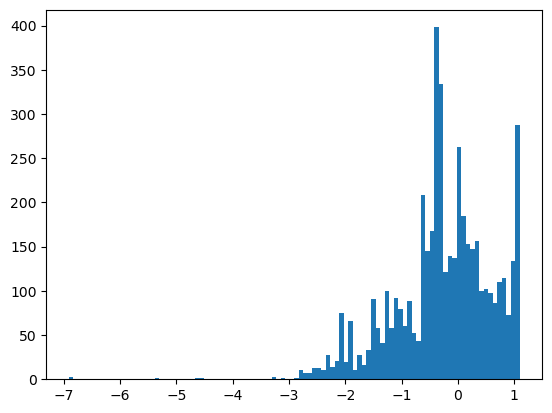

In [30]:
_ = plt.hist(np.log(train['redshift'].clip(1e-3, 3)), bins=100)

# Train and test on clean data

In [38]:
# Train model, test it, and extract uncertainty for any algorithm
#
#  Input: train_data (dict), test_data (dict), z_grid (array), 
#         informer_class (e.g., KNearNeighInformer), estimator_class (e.g., KNearNeighEstimator),
#         informer_kwargs (dict of params for informer), estimator_kwargs (dict of params for estimator),
#         label (str, identifier for output file, default 'output')
#  Output: uncertainty array (n_test_galaxies, 1), estimate_handle
#  Contributor: astra ·₊✧ 12/2025

def train_test_uncertainty(train_data, test_data, z_grid, informer_class, estimator_class, 
                          informer_kwargs=None, estimator_kwargs=None, label='output'):
    if informer_kwargs is None:
        informer_kwargs = {}
    if estimator_kwargs is None:
        estimator_kwargs = {}

    DS.clear()  # Clear DataStore to avoid conflicts

    # Debugging: Delete the model file if it already exists
    print(f"Model file exists before training: {os.path.exists(f'{label}_model.pkl')}")
    if os.path.exists(f'{label}_model.pkl'):
        os.remove(f'{label}_model.pkl')
        print(f"Deleted existing {label}_model.pkl")

    # Debugging: check DataStore contents before proceeding
    #print(f"\n[{label}] DataStore contents before inform: {list(DS.keys())}")
    #if 'input' in DS.keys():
    #    stored_input = DS['input'].data
    #    print(f"[{label}] DataStore already has input data, first u-mag: {stored_input['u_gaap1p0Mag'][0]}")
    
    # Train model

    # Debugging: Verify training data is different between runs
    #print(f"About to train with label '{label}'")
    #print(f"First galaxy u-band mag: {train_data['u_gaap1p0Mag'][0]}")
    #print(f"Training data object id: {id(train_data)}")
    
    informer = informer_class.make_stage(model=f'{label}_model.pkl', **informer_kwargs)
    model = informer.inform(train_data)

    # Debugging: Info to compare the created model
    print(f"Model object ID: {id(model)}")
    print(f"Model file hash: {hashlib.md5(open(model.path, 'rb').read()).hexdigest()}")
    print(f"Model type: {type(model)}")
    print(f"Model path: {model.path if hasattr(model, 'path') else 'N/A'}")
    print(f"Does model file exist? {os.path.exists(f'{label}_model.pkl')}")
    if os.path.exists(f'{label}_model.pkl'):
        print(f"File size: {os.path.getsize(f'{label}_model.pkl')}")
    print(f"Model in DataStore: {model in DS.values() if hasattr(DS, 'values') else 'N/A'}")
    
    # Test model
    estimator = estimator_class.make_stage(model=model, output=f'{label}_output.hdf5', **estimator_kwargs)
    estimate_handle = estimator.estimate(test_data)
    
    # Extract PDFs and calculate uncertainty
    ensemble = qp.read(estimate_handle.path)
    uncertainty = calc_std(ensemble, z_grid)
    
    return uncertainty, estimate_handle

In [39]:
# astra ·₊✧ 12/2025 .⋆˚★ Define noise parameters and establish baseline on clean data

noise_grid = np.logspace(-4, 0, 17) # Magnitudes of noise levels
z_grid = np.linspace(0., 4., 401)  # Redshift grid for PDF evaluation 

# Train and test on clean data using KNN
uncertainty_baseline, estimate_baseline = train_test_uncertainty(
    train, test, z_grid,
    KNearNeighInformer, KNearNeighEstimator,
    informer_kwargs={'nondetect_val': np.nan},
    label='baseline'
)

print(f"★ Baseline uncertainty: median={np.median(uncertainty_baseline):.4f}, mean={np.mean(uncertainty_baseline):.4f}")

train shape: 4803 galaxies
test shape: 1201 galaxies
train first u-mag: 25.005736412107943
test first u-mag: 22.680926767736672
Model file exists before training: True
Deleted existing baseline_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03888888888888889 and numneigh=7



Inserting handle into data store.  model: inprogress_baseline_model.pkl, KNearNeighInformer
Model object ID: 139784623970128
Model file hash: be9dcf8c6dee961ca6c88cc06ef93759
Model type: <class 'rail.core.data.ModelHandle'>
Model path: baseline_model.pkl
Does model file exist? True
File size: 327035
Model in DataStore: True
Process 0 running estimator on chunk 0 - 1,201
Process 0 estimating PZ PDF for rows 0 - 1,201
Inserting handle into data store.  output: inprogress_baseline_output.hdf5, KNearNeighEstimator
★ Baseline uncertainty: median=0.1745, mean=0.3456


In [35]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging: The data I train the model on differs, yet the output model is identical to baseline.
# What we know: 
#  - Training data going into inform is unique. 
#  - Original train dict is not corrupted. 
#  - Model output files are identical by hash, even with extreme data 
#  - Inform is not loading old model files from disk because we're deleting them first

# Extreme test: corrupt noisy training data so hyperparameters MUST differ

train_baseline = copy.deepcopy(train)
train_extreme = copy.deepcopy(train)
# shallow copies caused an issue once
#train_baseline = train.copy()
#train_extreme = train.copy()

# Make extreme dataset: add massive noise to force different hyperparameters
for band in 'ugrizy':
    train_extreme[f'u_gaap1p0Mag'] += 1000.0  
    train_extreme[f'g_gaap1p0Mag'] += 500.0   
    train_extreme[f'r_gaap1p0Mag'] += 333.0   

print(f"Baseline first u-mag: {train_baseline['u_gaap1p0Mag'][0]}")
print(f"Extreme first u-mag: {train_extreme['u_gaap1p0Mag'][0]}")

# Train both
uncertainty_baseline_test, _ = train_test_uncertainty(
    train_baseline, test, z_grid,
    KNearNeighInformer, KNearNeighEstimator,
    informer_kwargs={'nondetect_val': np.nan},
    label='baseline_test'
)

uncertainty_extreme_test2, _ = train_test_uncertainty(
    train_extreme, test, z_grid,
    KNearNeighInformer, KNearNeighEstimator,
    informer_kwargs={'nondetect_val': np.nan},
    label='extreme_test2'
)

# Check hashes
import hashlib
with open('baseline_test_model.pkl', 'rb') as f:
    hash1 = hashlib.md5(f.read()).hexdigest()
with open('extreme_test2_model.pkl', 'rb') as f:
    hash2 = hashlib.md5(f.read()).hexdigest()
    
print(f"Baseline test hash: {hash1}")
print(f"Extreme test hash: {hash2}")
print(f"★ Still identical? {hash1 == hash2}")

Baseline first u-mag: 25.005736412107943
Extreme first u-mag: 6025.005736412108
Model file exists before training: True
Deleted existing baseline_test_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03888888888888889 and numneigh=7



Inserting handle into data store.  model: inprogress_baseline_test_model.pkl, KNearNeighInformer
Model object ID: 139784642019632
Model file hash: be9dcf8c6dee961ca6c88cc06ef93759
Model type: <class 'rail.core.data.ModelHandle'>
Model path: baseline_test_model.pkl
Does model file exist? True
File size: 327035
Model in DataStore: True
Process 0 running estimator on chunk 0 - 1,201
Process 0 estimating PZ PDF for rows 0 - 1,201
Inserting handle into data store.  output: inprogress_baseline_test_output.hdf5, KNearNeighEstimator
Model file exists before training: True
Deleted existing extreme_test2_model.pkl
Ins

In [50]:
# astra ·₊✧ 12/2025 .⋆˚★ Train and test with matched Gaussian noise levels, track uncertainty calibration

# Experiment configuration
TRAIN_ON_MIXED_NOISE = True  # Toggle: True = train 1 model on heterogeneous noise, False = train N models (1 per noise level)

uncertainty_ratios = []
noise_levels_tested = []

# Algorithm configuration
algo_informer = KNearNeighInformer
algo_estimator = KNearNeighEstimator
algo_kwargs = {'nondetect_val': np.nan}


# Train and test with noise
if TRAIN_ON_MIXED_NOISE: # Train once on mixed noise
    train_mixed = create_mixed_noise_data(copy.deepcopy(train), noise_grid)
    test_mixed = create_mixed_noise_data(copy.deepcopy(test), noise_grid)


    
    # Debugging: Verify data is actually noisy
    print(f"Original train u-band first 3: {train['u_gaap1p0Mag'][:3]}")
    print(f"Noisy train u-band first 3: {train_mixed['u_gaap1p0Mag'][:3]}")
    print(f"Original test u-band first 3: {test['u_gaap1p0Mag'][:3]}")
    print(f"Noisy test u-band first 3: {test_mixed['u_gaap1p0Mag'][:3]}")
    
    uncertainty_noisy, estimate_noisy = train_test_uncertainty(
        train_mixed, test_mixed, z_grid,
        algo_informer, algo_estimator,
        informer_kwargs=algo_kwargs,
        label='noisy'
    )
    
    # Calculate uncertainty ratio
    ratio = np.median(uncertainty_noisy / uncertainty_baseline)
    uncertainty_ratios.append(ratio)
    noise_levels_tested.append("mixed")
    print(f"★ Mixed noise model uncertainty ratio: {ratio:.4f}")

else: # Train separate model for each noise level
    for noise in noise_grid:
        print(f"\nProcessing noise level: {noise:.2f} mag")

        # Apply noise to both train and test data
        train_noisy = smear_data(copy.deepcopy(train), noise * np.ones(6))
        test_noisy = smear_data(copy.deepcopy(test), noise * np.ones(6))
        
        uncertainty_noisy, estimate_noisy = train_test_uncertainty(
            train_noisy, test_noisy, z_grid,
            algo_informer, algo_estimator,
            informer_kwargs=algo_kwargs,
            label='noisy'
        )
            
        # Calculate uncertainty ratios for each
        ratio = np.median(uncertainty_noisy / uncertainty_baseline)
        uncertainty_ratios.append(ratio)
        noise_levels_tested.append(noise)
        print(f"★ Per noise level model uncertainty ratio: {ratio:.4f}")

# Debugging: Verify we're reading from the noisy file
print(f"Noisy estimate loaded from: {estimate_noisy.path}")
print(f"Noisy estimate first 5 predictions: {estimate_noisy.data.ancil['zmode'][:5].flatten()}")
print(f"Baseline estimate first 5 predictions: {estimate_baseline.data.ancil['zmode'][:5].flatten()}")

Original train u-band first 3: [25.00573641 24.75744639 22.25320105]
Noisy train u-band first 3: [24.82299792 24.86271473 22.25177593]
Original test u-band first 3: [22.68092677 23.32366161 22.88814623]
Noisy test u-band first 3: [22.78005953 23.32364046 22.88821282]
train shape: 4803 galaxies
test shape: 1201 galaxies
train first u-mag: 25.005736412107943
test first u-mag: 22.680926767736672
Model file exists before training: True
Deleted existing noisy_model.pkl
Inserting handle into data store.  input: None, KNearNeighInformer
split into 3602 training and 1201 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03888888888888889 and numneigh=7



Inserting handle into data store.  model: inprogress_noisy_model.pkl, KNearNeighInformer
Model object ID: 139784642030960
Model file hash: be9dcf8c6dee961ca6c88cc06ef93759
Model type: <class 'rail.core.data.ModelHandle'>
Model path: noisy_model.pkl
Does model file exist? True
File size: 327035
Model in Dat

In [51]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging: Are the files identical, and/or are they pointing to the same file?
print("Files matching *model.pkl:")
import glob
for f in glob.glob("*model.pkl"):
    print(f"  {f}: {os.path.getsize(f)} bytes")

print(f"baseline inode: {os.stat('baseline_model.pkl').st_ino}")
print(f"noisy inode: {os.stat('noisy_model.pkl').st_ino}")

Files matching *model.pkl:
  baseline_model.pkl: 327035 bytes
  noisy_model.pkl: 327035 bytes
  extreme_test2_model.pkl: 327035 bytes
  baseline_test_model.pkl: 327035 bytes
  extreme_test_model.pkl: 327035 bytes
baseline inode: 522229
noisy inode: 513975


In [44]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging
print(f"estimate_baseline first 3 zmode: {estimate_baseline.data.ancil['zmode'][:3]}")
print(f"estimate_noisy first 3 zmode: {estimate_noisy.data.ancil['zmode'][:3]}")
print(f"Are they identical? {np.array_equal(estimate_baseline.data.ancil['zmode'], estimate_noisy.data.ancil['zmode'])}")
print(f"estimate_baseline path: {estimate_baseline.path}")
print(f"estimate_noisy path: {estimate_noisy.path}")
print(f"Same file? {estimate_baseline.path == estimate_noisy.path}")
print(f"Same object in memory? {estimate_baseline is estimate_noisy}")
# Check if .data loads fresh from disk each time
print("Accessing estimate_baseline.data.ancil NOW (after noisy training):")
print(estimate_baseline.data.ancil['zmode'][:3])
print(f"This reads from: {estimate_baseline.path}")

estimate_baseline first 3 zmode: [[0.52]
 [0.33]
 [0.2 ]]
estimate_noisy first 3 zmode: [[0.52]
 [0.33]
 [0.2 ]]
Are they identical? True
estimate_baseline path: baseline_output.hdf5
estimate_noisy path: noisy_output.hdf5
Same file? False
Same object in memory? False
Accessing estimate_baseline.data.ancil NOW (after noisy training):
[[0.52]
 [0.33]
 [0.2 ]]
This reads from: baseline_output.hdf5


In [46]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging: More ways to check if models and outputs are actually different (from before I used file hashes)
# Check if any predictions differ at all
diff_count = (estimate_baseline.data.ancil['zmode'] != estimate_noisy.data.ancil['zmode']).sum()
print(f"Number of different predictions: {diff_count} out of {len(estimate_baseline.data.ancil['zmode'])}")

# Check uncertainty values
print(f"Baseline uncertainty median: {np.median(uncertainty_baseline):.4f}")
print(f"Noisy uncertainty median: {np.median(uncertainty_noisy):.4f}")

Number of different predictions: 0 out of 1201
Baseline uncertainty median: 0.1745
Noisy uncertainty median: 0.1745


In [52]:
# astra ·₊✧ 12/2025 .⋆˚★ Debugging: Verify models contain different data by checking file content hash
import hashlib
with open('baseline_model.pkl', 'rb') as f:
    baseline_hash = hashlib.md5(f.read()).hexdigest()
with open('noisy_model.pkl', 'rb') as f:
    noisy_hash = hashlib.md5(f.read()).hexdigest()
print(f"Baseline model hash: {baseline_hash}")
print(f"Noisy model hash: {noisy_hash}")
print(f"Models identical? {baseline_hash == noisy_hash}")

Baseline model hash: be9dcf8c6dee961ca6c88cc06ef93759
Noisy model hash: be9dcf8c6dee961ca6c88cc06ef93759
Models identical? True


In [134]:
# Baseline ancillary data (summary statistics and metadata)
estimate_baseline.data.ancil

{'distribution_type': array([0, 0, 0, ..., 0, 0, 0]),
 'redshift': array([0.44316, 0.33899, 0.21898, ..., 0.84497, 0.2893 , 0.26602]),
 'zmode': array([[0.52],
        [0.33],
        [0.2 ],
        ...,
        [2.72],
        [0.67],
        [0.28]])}

In [135]:
estimate_noisy.data.ancil

{'distribution_type': array([0, 0, 0, ..., 0, 0, 0]),
 'redshift': array([0.44316, 0.33899, 0.21898, ..., 0.84497, 0.2893 , 0.26602]),
 'zmode': array([[0.52],
        [0.33],
        [0.2 ],
        ...,
        [2.72],
        [0.67],
        [0.28]])}

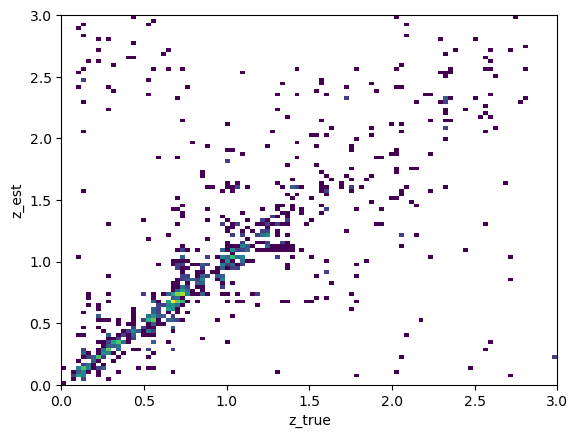

In [136]:
# Visualize baseline performance: z_true vs z_estimated
_ = plt.hist2d(
     np.squeeze(estimate_baseline.data.ancil['zmode']),
    estimate_baseline.data.ancil['redshift'],
    bins=(np.linspace(0.,3, 101), np.linspace(0.,3, 101)), norm='log',
)
_ = plt.xlabel("z_true")
_ = plt.ylabel("z_est")

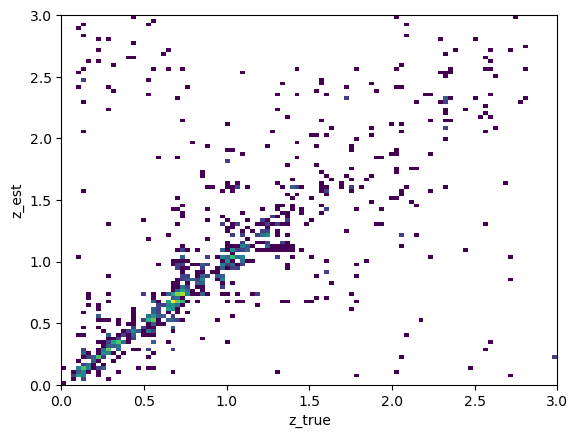

In [55]:
# Visualize noisy performance: z_true vs z_estimated
_ = plt.hist2d(
     np.squeeze(estimate_noisy.data.ancil['zmode']),
    estimate_noisy.data.ancil['redshift'],
    bins=(np.linspace(0.,3, 101), np.linspace(0.,3, 101)), norm='log',
)
_ = plt.xlabel("z_true")
_ = plt.ylabel("z_est")

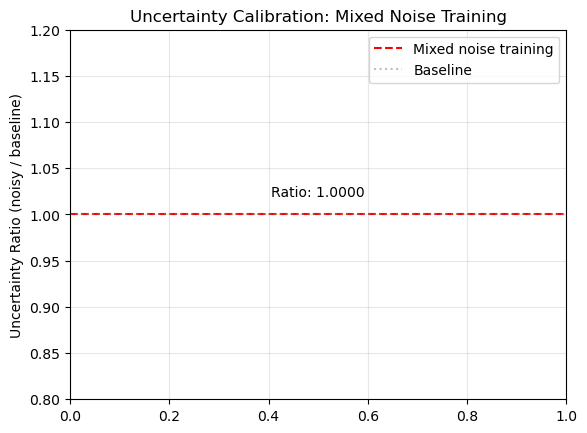

Uncertainty ratios: [np.float64(1.0)]
Noise levels tested: ['mixed']
Current x-limits: (np.float64(0.0), np.float64(1.0))
Current y-limits: (np.float64(0.0), np.float64(1.0))


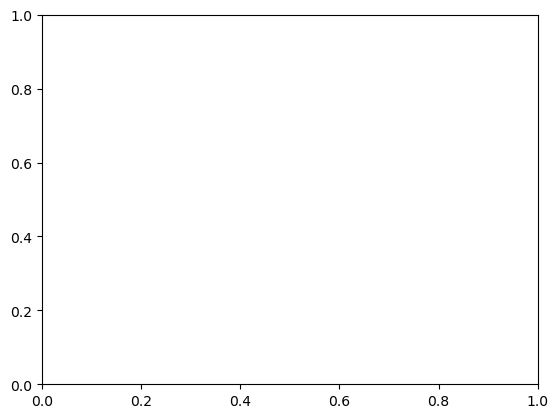

In [57]:
#  astra ·₊✧ 12/2025 .⋆˚★ ///// WORK IN PROGRESS ///// Visualize uncertainty calibration with noise

if TRAIN_ON_MIXED_NOISE:
    _ = plt.axhline(y=uncertainty_ratios[0], color='red', linestyle='--', label='Mixed noise training')
    _ = plt.text(0.5, uncertainty_ratios[0] + 0.02, f'Ratio: {uncertainty_ratios[0]:.4f}', ha='center')
    _ = plt.xlim(0, 1)
    _ = plt.title('Uncertainty Calibration: Mixed Noise Training')
else:
    _ = plt.plot(noise_levels_tested, uncertainty_ratios, 'o-', color='red', label='Uncertainty ratio')
    _ = plt.xscale('log')
    _ = plt.xlabel('Gaussian Noise Level (mag)')
    _ = plt.title('Uncertainty Calibration: Per-Level Training')

_ = plt.ylabel('Uncertainty Ratio (noisy / baseline)')
_ = plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, label='Baseline')
_ = plt.legend()
_ = plt.grid(True, alpha=0.3)
_ = plt.ylim(0.8, 1.2)
plt.show()
print(f"Uncertainty ratios: {uncertainty_ratios}")
print(f"Noise levels tested: {noise_levels_tested}")
print(f"Current x-limits: {plt.xlim()}")
print(f"Current y-limits: {plt.ylim()}")